In [1]:
import anndata as ad, pandas as pd, numpy as np
from pathlib import Path
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
ROOT = Path("/gpfs/home/asun/jin_lab/perturbench")
DS   = ROOT/"0_datasets/boli_251006_1"
SPLIT= DS/"splits/boli_251006_1_qual_high_amt_high_split.csv"
GT   = DS/"data/boli_251006_1_qual_high_amt_high.h5ad"
PRED = ROOT/"2_predict/logs/predict/runs/2025-09-24_08-49-57_boli_qual_high_amt_high/predictions/prediction_chunk_0.h5ad"

In [3]:
df_split = pd.read_csv(SPLIT, header=None, names=["cell_id","split"])
test_ids = set(df_split.loc[df_split["split"].str.lower()=="test","cell_id"].astype(str))
print("n test cells:", len(test_ids))

n test cells: 3033


In [46]:
adata = ad.read_h5ad(GT)
adata = adata[adata.obs_names.astype(str).isin(test_ids)].copy()
print("GT test shape:", adata.shape)


PERT_COL = "condition"
ctrl_labels = {"ctrl"}
adata = adata[~adata.obs[PERT_COL].astype(str).str.lower().isin(ctrl_labels)].copy()

print("After removing control cells:", adata.shape)

GT test shape: (3033, 5000)
After removing control cells: (2724, 5000)


contain only pertubation without control

In [48]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,seurat_clusters,Assign,scds,cxds,bcds,Sample,nCount_refAssay,...,mito,BioSamp,CT2,ForPlot,Remove,active_ident,Assign_clean,condition,cell_type,cell_class
batch1_samp1_chan1_AAACCTGAGGCCGAAT-1,batch1,6016,2767,21,Bcl11b_0,0.487555,9829.195327,0.337222,batch1_samp1_chan1,6016,...,0.016622,batch1_samp1,029 L6b CTX Glut,batch1_samp1_Bcl11b_0,False,21,Bcl11b,BCL11B,L6b_CTX,ctL6
batch1_samp1_chan1_AAACCTGCACTATCTT-1,batch1,5713,2476,21,Xpo7_0,0.557018,17380.257353,0.294270,batch1_samp1_chan1,5713,...,0.000000,batch1_samp1,029 L6b CTX Glut,batch1_samp1_Xpo7_0,False,21,Xpo7,XPO7,L6b_CTX,ctL6
batch1_samp1_chan1_AAACCTGGTTGTCGCG-1,batch1,2753,1647,1,Bcl11b_0,0.402012,20130.806125,0.100382,batch1_samp1_chan1,2753,...,0.145296,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Bcl11b_0,False,1,Bcl11b,BCL11B,L6_CT_CTX,ctL6
batch1_samp1_chan1_AAACCTGTCAATCACG-1,batch1,8445,3434,5,Bcl11b_0,1.048757,15141.391509,0.813467,batch1_samp1_chan1,8445,...,0.011841,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Bcl11b_0,False,5,Bcl11b,BCL11B,L6_CT_CTX,ctL6
batch1_samp1_chan1_AAACGGGCAGCTTAAC-1,batch1,2551,1453,1,Bcl11b_0,0.137781,8253.845535,0.014745,batch1_samp1_chan1,2551,...,0.000000,batch1_samp1,030 L6 CT CTX Glut,batch1_samp1_Bcl11b_0,False,1,Bcl11b,BCL11B,L6_CT_CTX,ctL6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch2_mouse3_chan7_TTTACTGGTTCGGGCT-1,batch2,7967,3369,2,Cx3cl1_0,0.244281,821.135399,0.170881,batch2_mouse3_chan7,7967,...,0.000000,batch2_mouse3,004 L6 IT CTX Glut,batch2_mouse3_Cx3cl1_0,False,2,Cx3cl1,CX3CL1,L6_IT_CTX,itRSP
batch2_mouse3_chan7_TTTATGCGTCAATACC-1,batch2,5834,2665,3,Bcl11b_0,0.220856,1713.983810,0.068730,batch2_mouse3_chan7,5834,...,0.017141,batch2_mouse3,030 L6 CT CTX Glut,batch2_mouse3_Bcl11b_0,False,3,Bcl11b,BCL11B,L6_CT_CTX,ctL6
batch2_mouse3_chan7_TTTGCGCCACTACAGT-1,batch2,6786,2764,3,Bcl11b_0,0.407364,2369.211779,0.195698,batch2_mouse3_chan7,6786,...,0.014736,batch2_mouse3,030 L6 CT CTX Glut,batch2_mouse3_Bcl11b_0,False,3,Bcl11b,BCL11B,L6_CT_CTX,ctL6
batch2_mouse3_chan7_TTTGCGCCAGATCTGT-1,batch2,5941,2759,2,Cx3cl1_0,0.380554,3683.211344,0.052962,batch2_mouse3_chan7,5941,...,0.067329,batch2_mouse3,004 L6 IT CTX Glut,batch2_mouse3_Cx3cl1_0,False,2,Cx3cl1,CX3CL1,L6_IT_CTX,itRSP


In [ ]:
pred = ad.read_h5ad(PRED)

In [7]:
adata.var

,variable_gene,gene_name,highly_variable,means,dispersions,dispersions_norm
4,False,Rp1,True,0.003066,0.823780,1.561084
5,True,Sox17,True,0.000705,2.184636,5.183929
7,False,Gm37323,True,0.000366,0.772251,1.423905
11,True,Rgs20,True,0.319385,0.535013,0.983012
14,True,Oprk1,True,0.033648,0.509697,0.724937
...,...,...,...,...,...,...
32203,True,mt-Nd4l,True,0.148192,0.693679,1.214733
32204,True,mt-Nd4,True,0.065243,0.498341,0.694706
32205,True,mt-Nd5,True,0.054451,0.428846,0.509697
32207,True,mt-Cytb,True,0.235478,0.937770,1.864546


In [8]:
adata.var

,variable_gene,gene_name,highly_variable,means,dispersions,dispersions_norm
4,False,Rp1,True,0.003066,0.823780,1.561084
5,True,Sox17,True,0.000705,2.184636,5.183929
7,False,Gm37323,True,0.000366,0.772251,1.423905
11,True,Rgs20,True,0.319385,0.535013,0.983012
14,True,Oprk1,True,0.033648,0.509697,0.724937
...,...,...,...,...,...,...
32203,True,mt-Nd4l,True,0.148192,0.693679,1.214733
32204,True,mt-Nd4,True,0.065243,0.498341,0.694706
32205,True,mt-Nd5,True,0.054451,0.428846,0.509697
32207,True,mt-Cytb,True,0.235478,0.937770,1.864546


In [9]:
adata

AnnData object with n_obs × n_vars = 2724 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_clean', 'condition', 'cell_type', 'cell_class'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [10]:
pred

AnnData object with n_obs × n_vars = 2024 × 5000
    obs: 'cell_class', 'condition'

## only keep common from raw and prediction

In [11]:
common = adata.var_names.astype(str).intersection(pred.var_names.astype(str))


In [12]:
common

Index(['4', '5', '7', '11', '14', '18', '19', '27', '41', '42',
       ...
       '32197', '32198', '32199', '32200', '32201', '32203', '32204', '32205',
       '32207', '32261'],
      dtype='object', length=5000)

In [ ]:
PERT_COL = "condition"
Xpred = pred.layers["pred"] if "pred" in pred.layers else pred.obsm.get("pred", pred.X)
Xpred

array([[0.00456652, 0.00239026, 0.0027293 , ..., 0.03403563, 0.10912979,
        0.0395272 ],
       [0.00456652, 0.00239961, 0.0027293 , ..., 0.03423226, 0.10973717,
        0.03990746],
       [0.00456652, 0.00239026, 0.0027293 , ..., 0.03403563, 0.1093319 ,
        0.03960297],
       ...,
       [0.00484142, 0.00253432, 0.00290507, ..., 0.03436396, 0.10732672,
        0.04029131],
       [0.00482259, 0.00253432, 0.00289376, ..., 0.03429805, 0.10732672,
        0.04021425],
       [0.00484142, 0.00253432, 0.00290507, ..., 0.03436396, 0.10752566,
        0.04021425]], dtype=float32)

In [14]:
adata.var

,variable_gene,gene_name,highly_variable,means,dispersions,dispersions_norm
4,False,Rp1,True,0.003066,0.823780,1.561084
5,True,Sox17,True,0.000705,2.184636,5.183929
7,False,Gm37323,True,0.000366,0.772251,1.423905
11,True,Rgs20,True,0.319385,0.535013,0.983012
14,True,Oprk1,True,0.033648,0.509697,0.724937
...,...,...,...,...,...,...
32203,True,mt-Nd4l,True,0.148192,0.693679,1.214733
32204,True,mt-Nd4,True,0.065243,0.498341,0.694706
32205,True,mt-Nd5,True,0.054451,0.428846,0.509697
32207,True,mt-Cytb,True,0.235478,0.937770,1.864546


In [30]:
pred.obs['condition'].unique()

['BCL11B', 'TRIO', 'ANK3', 'DAB1', 'HERC1', ..., 'TBR1', 'SATB2', 'CUL1', 'RB1CC1', 'CX3CL1']
Length: 11
Categories (11, object): ['ANK3', 'BCL11B', 'CUL1', 'CX3CL1', ..., 'SATB2', 'TBR1', 'TRIO', 'XPO7']

## Systema Evaluation

The following cells will run the complete Systema evaluation pipeline:
- **Systematic Variation**: Quantifies pairwise similarities between perturbation shifts
- **Centroid Accuracy**: Measures how well predictions identify the correct perturbation
- **PearsonΔ Metrics**: Correlation between predicted and true deltas (all genes and top 20 DE)


In [16]:
adata = adata[:, common].copy()
pred  = pred[:,  common].copy()

In [ ]:
#calculation of centroid accuracy

from systema.evaluation.centroid_accuracy import calculate_centroid_accuracies

# 1: Compute ground-truth centroids (mean expression per condition)
print("Step 1: Computing ground-truth centroids...")
post_gt_all_df = pd.DataFrame(columns=adata.var_names)

for condition in adata.obs[PERT_COL].unique():
    if str(condition).lower() == 'ctrl':
        continue
    mask = adata.obs[PERT_COL] == condition
    if mask.sum() > 0:
        centroid = np.array(adata[mask].X.mean(axis=0)).ravel()
        post_gt_all_df.loc[condition] = centroid

print(f"  Ground-truth shape: {post_gt_all_df.shape}")
print(f"  Conditions: {list(post_gt_all_df.index)}")

# 2: Compute predicted centroids (mean prediction per condition)
print("\nStep 2: Computing predicted centroids...")
post_pred_df = pd.DataFrame(columns=pred.var_names)

for condition in pred.obs[PERT_COL].unique():
    if str(condition).lower() == 'ctrl':
        continue
    mask = pred.obs[PERT_COL] == condition
    if mask.sum() > 0:
        # Use Xpred if available, otherwise use pred.X
        if Xpred.shape[0] == len(pred.obs):
            centroid = np.array(Xpred[mask].mean(axis=0)).ravel()
        else:
            centroid = np.array(pred[mask].X.mean(axis=0)).ravel()
        post_pred_df.loc[condition] = centroid

print(f"  Predicted shape: {post_pred_df.shape}")

# 3: Align genes (ensure both have same genes)
print("\nStep 3: Aligning genes...")
common_genes = post_gt_all_df.columns.intersection(post_pred_df.columns)
post_gt_all_df = post_gt_all_df[common_genes] 
post_pred_df = post_pred_df[common_genes] #model predicted centroids
print(f"  Common genes: {len(common_genes)}")

# 4: Convert predictions to MultiIndex format
print("\nStep 4: Converting to MultiIndex format...")
method_name = "model"
agg_post_pred_df = post_pred_df.copy()

# each row becomes (condition, method)
agg_post_pred_df.index = pd.MultiIndex.from_tuples(
    [(cond, method_name) for cond in agg_post_pred_df.index],
    names=['condition', 'method']
)

print(f"  MultiIndex shape: {agg_post_pred_df.shape}")
print(f"  MultiIndex names: {agg_post_pred_df.index.names}")
print(f"  Sample indices: {list(agg_post_pred_df.index[:3])}")

# Verify format matches requirements
print("\n: Verifying format...")
print(f"  post_gt_all_df:")
print(f"    - Index type: {type(post_gt_all_df.index)}")
print(f"    - Index values: {list(post_gt_all_df.index)}")
print(f"    - Columns: {len(post_gt_all_df.columns)} genes")
print(f"\n  agg_post_pred_df:")
print(f"    - Index type: {type(agg_post_pred_df.index)}")
print(f"    - Index names: {agg_post_pred_df.index.names}")
print(f"    - Columns: {len(agg_post_pred_df.columns)} genes")
print(f"    - Same genes as GT: {list(post_gt_all_df.columns) == list(agg_post_pred_df.columns)}")


Step 1: Computing ground-truth centroids...
  Ground-truth shape: (5, 5000)
  Conditions: ['BCL11B', 'XPO7', 'TBR1', 'CX3CL1', 'HERC1']

Step 2: Computing predicted centroids...
  Predicted shape: (11, 5000)

Step 3: Aligning genes...
  Common genes: 5000

Step 4: Converting to MultiIndex format...
  MultiIndex shape: (11, 5000)
  MultiIndex names: ['condition', 'method']
  Sample indices: [('BCL11B', 'model'), ('TRIO', 'model'), ('ANK3', 'model')]

Step 5: Verifying format...
  post_gt_all_df:
    - Index type: <class 'pandas.core.indexes.base.Index'>
    - Index values: ['BCL11B', 'XPO7', 'TBR1', 'CX3CL1', 'HERC1']
    - Columns: 5000 genes

  agg_post_pred_df:
    - Index type: <class 'pandas.core.indexes.multi.MultiIndex'>
    - Index names: ['condition', 'method']
    - Columns: 5000 genes
    - Same genes as GT: True


In [37]:
agg_post_pred_df

,,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
condition,method,,,,,,,,,,,,,,,,,,,,,
BCL11B,model,0.004563,0.002409,0.002731,0.216213,0.025691,0.006721,0.006196,0.903793,0.211963,0.117139,...,0.155633,0.143781,0.039018,0.162765,0.112677,0.075906,0.039876,0.034149,0.110270,0.039688
TRIO,model,0.004366,0.002179,0.002409,0.199937,0.021674,0.005797,0.005322,0.870385,0.207007,0.115764,...,0.155378,0.137829,0.033518,0.170669,0.105297,0.073821,0.039689,0.032523,0.104746,0.037851
ANK3,model,0.004520,0.002342,0.002720,0.203214,0.022220,0.006212,0.005854,0.896701,0.207052,0.122085,...,0.151467,0.137275,0.034191,0.156206,0.106366,0.071603,0.039055,0.032372,0.107149,0.037318
DAB1,model,0.004630,0.002423,0.002755,0.209209,0.022307,0.006799,0.005932,0.868718,0.210807,0.121947,...,0.153023,0.138362,0.035582,0.148534,0.106435,0.070421,0.040288,0.033006,0.108124,0.038697
HERC1,model,0.004607,0.002375,0.002802,0.205072,0.022265,0.006338,0.005988,0.907363,0.212220,0.124966,...,0.151130,0.137717,0.034501,0.155068,0.106576,0.071479,0.038958,0.032617,0.107629,0.037425
XPO7,model,0.004796,0.002537,0.002915,0.208264,0.024204,0.007012,0.006514,0.919321,0.222017,0.116840,...,0.153165,0.140246,0.038632,0.158284,0.110738,0.074100,0.040010,0.034320,0.108820,0.040060
TBR1,model,0.004992,0.002992,0.002815,0.265395,0.036416,0.007448,0.005961,0.928444,0.221844,0.232916,...,0.167356,0.170342,0.036347,0.169398,0.128876,0.081995,0.040181,0.036803,0.121136,0.048047
SATB2,model,0.004766,0.002423,0.002733,0.231033,0.023685,0.007215,0.005968,0.892550,0.229014,0.128926,...,0.152790,0.137556,0.036394,0.146953,0.105782,0.070629,0.040020,0.034176,0.108811,0.039860
CUL1,model,0.004695,0.003388,0.003003,0.108284,0.019064,0.007776,0.007616,0.739896,0.162899,0.129322,...,0.157244,0.141556,0.040847,0.152912,0.130595,0.076013,0.034312,0.034859,0.118602,0.051665


In [38]:
post_gt_all_df

,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
BCL11B,0.000914,0.0,0.000000,0.187542,0.020978,0.015125,0.002301,0.875506,0.165063,0.142485,...,0.146689,0.132864,0.044075,0.156135,0.118122,0.075669,0.028471,0.026440,0.118341,0.051710
XPO7,0.001916,0.0,0.000000,0.232623,0.007289,0.008104,0.002366,0.904388,0.192868,0.131776,...,0.169559,0.175202,0.038274,0.187151,0.148681,0.098890,0.036362,0.038301,0.129707,0.029135
TBR1,0.005372,0.0,0.000000,0.185672,0.010559,0.000000,0.000931,0.232812,0.024337,0.105181,...,0.211968,0.201864,0.078520,0.230740,0.175920,0.125666,0.042847,0.040361,0.179683,0.030750
CX3CL1,0.004830,0.0,0.002975,0.201436,0.073195,0.006705,0.004419,0.439657,0.020229,0.028552,...,0.160514,0.194141,0.048651,0.221741,0.162720,0.114221,0.040837,0.030450,0.124520,0.039951
HERC1,0.004016,0.0,0.000000,0.086295,0.005012,0.003226,0.000000,0.314014,0.019851,0.101458,...,0.183109,0.137908,0.022333,0.162192,0.121267,0.058043,0.029520,0.022116,0.099578,0.025473


In [ ]:
post_gt_all_df #GT centroids

,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
BCL11B,0.000914,0.0,0.000000,0.187542,0.020978,0.015125,0.002301,0.875506,0.165063,0.142485,...,0.146689,0.132864,0.044075,0.156135,0.118122,0.075669,0.028471,0.026440,0.118341,0.051710
XPO7,0.001916,0.0,0.000000,0.232623,0.007289,0.008104,0.002366,0.904388,0.192868,0.131776,...,0.169559,0.175202,0.038274,0.187151,0.148681,0.098890,0.036362,0.038301,0.129707,0.029135
TBR1,0.005372,0.0,0.000000,0.185672,0.010559,0.000000,0.000931,0.232812,0.024337,0.105181,...,0.211968,0.201864,0.078520,0.230740,0.175920,0.125666,0.042847,0.040361,0.179683,0.030750
CX3CL1,0.004830,0.0,0.002975,0.201436,0.073195,0.006705,0.004419,0.439657,0.020229,0.028552,...,0.160514,0.194141,0.048651,0.221741,0.162720,0.114221,0.040837,0.030450,0.124520,0.039951
HERC1,0.004016,0.0,0.000000,0.086295,0.005012,0.003226,0.000000,0.314014,0.019851,0.101458,...,0.183109,0.137908,0.022333,0.162192,0.121267,0.058043,0.029520,0.022116,0.099578,0.025473


CALCULATING SYSTEMATIC VARIATION

Step 1: Computing perturbation mean reference...
  Perturbation mean shape: (5000,)

Step 2: Computing perturbation shifts...
  GT shifts shape: (5, 5000)
  Pred shifts shape: (5, 5000)

Step 3: Calculating pairwise cosine similarities...
  GT pairwise similarities: 10 pairs
  Pred pairwise similarities: 10 pairs

RESULTS: Systematic Variation (Pairwise Perturbation Similarities)

Ground Truth:
  Mean: -0.2372
  Std:  0.4576
  Min:  -0.7083
  Max:  0.9164

Predictions:
  Mean: 0.9203
  Std:  0.0892
  Min:  0.7989
  Max:  0.9995


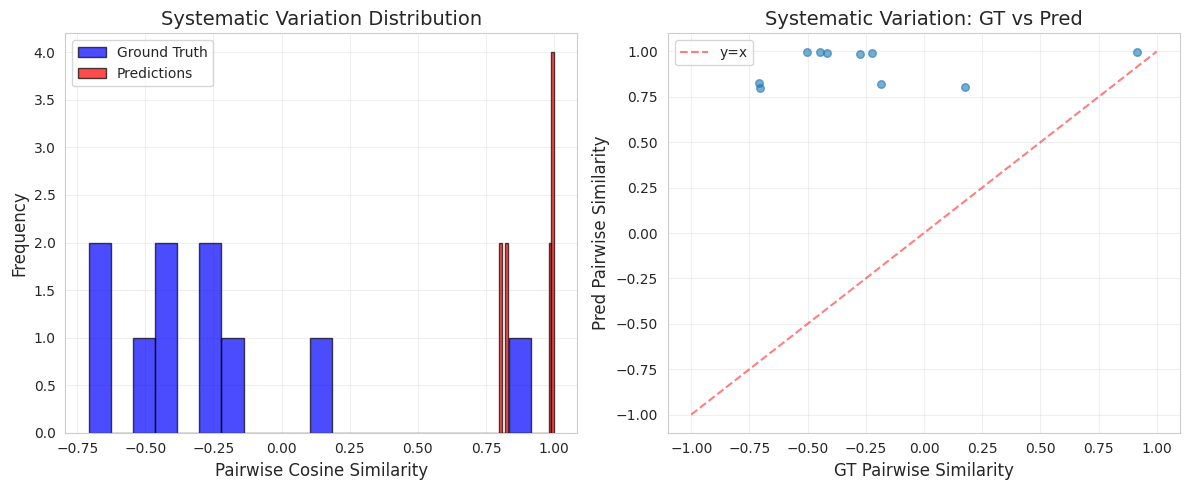

In [ ]:
# Calculate Systematic Variation using the centroids
# This uses the cosine similarity functions you have

from sklearn.metrics.pairwise import cosine_similarity

print("=" * 80)
print("CALCULATING SYSTEMATIC VARIATION")
print("=" * 80)

# 1: Compute perturbation mean as reference
# average of all perturbation centroids
print("\nStep 1: Computing perturbation mean reference...")
pert_mean = post_gt_all_df.values.mean(axis=0)
print(f"  Perturbation mean shape: {pert_mean.shape}")

# 2: Compute perturbation shifts (centroid - reference) for GT
print("\nStep 2: Computing perturbation shifts...")
pert_shifts_gt = []
conditions_list = list(post_gt_all_df.index)

for condition in conditions_list:
    shift = post_gt_all_df.loc[condition].values - pert_mean
    pert_shifts_gt.append(shift)

pert_shifts_gt = np.array(pert_shifts_gt)
print(f"  GT shifts shape: {pert_shifts_gt.shape}")

# 3: Compute perturbation shifts for predictions
pert_shifts_pred = []
for condition in conditions_list:
    if condition in post_pred_df.index:
        shift = post_pred_df.loc[condition].values - pert_mean
        pert_shifts_pred.append(shift)

pert_shifts_pred = np.array(pert_shifts_pred)
print(f"  Pred shifts shape: {pert_shifts_pred.shape}")

# 4: Calculate pairwise cosine similarities
print("\nStep 3: Calculating pairwise cosine similarities...")

def calculate_pairwise_cosine_similarities(pert_shifts):
    """Calculate pairwise cosine similarities between all perturbation shifts."""
    sims = cosine_similarity(pert_shifts)
    # Extract upper triangle (excluding diagonal)
    n = len(pert_shifts)
    return sims[np.triu_indices(n, k=1)]

pairwise_sims_gt = calculate_pairwise_cosine_similarities(pert_shifts_gt)
pairwise_sims_pred = calculate_pairwise_cosine_similarities(pert_shifts_pred)

print(f"  GT pairwise similarities: {len(pairwise_sims_gt)} pairs")
print(f"  Pred pairwise similarities: {len(pairwise_sims_pred)} pairs")

# 5: Summary statistics
print("\n" + "=" * 80)
print("RESULTS: Systematic Variation (Pairwise Perturbation Similarities)")
print("=" * 80)
print(f"\nGround Truth:")
print(f"  Mean: {pairwise_sims_gt.mean():.4f}")
print(f"  Std:  {pairwise_sims_gt.std():.4f}")
print(f"  Min:  {pairwise_sims_gt.min():.4f}")
print(f"  Max:  {pairwise_sims_gt.max():.4f}")

print(f"\nPredictions:")
print(f"  Mean: {pairwise_sims_pred.mean():.4f}")
print(f"  Std:  {pairwise_sims_pred.std():.4f}")
print(f"  Min:  {pairwise_sims_pred.min():.4f}")
print(f"  Max:  {pairwise_sims_pred.max():.4f}")

# 6: Visualize
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(pairwise_sims_gt, bins=20, alpha=0.7, label='Ground Truth', color='blue', edgecolor='black')
axes[0].hist(pairwise_sims_pred, bins=20, alpha=0.7, label='Predictions', color='red', edgecolor='black')
axes[0].set_xlabel('Pairwise Cosine Similarity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Systematic Variation Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(pairwise_sims_gt, pairwise_sims_pred, alpha=0.6, s=30)
axes[1].plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label='y=x')
axes[1].set_xlabel('GT Pairwise Similarity', fontsize=12)
axes[1].set_ylabel('Pred Pairwise Similarity', fontsize=12)
axes[1].set_title('Systematic Variation: GT vs Pred', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("=" * 80)
print("CALCULATING SIMILARITY TO AVERAGE SHIFT")
print("=" * 80)

# Compute average shift
avg_shift = pert_shifts_gt.mean(axis=0)
print(f"\nAverage shift shape: {avg_shift.shape}")

# Calculate cosine similarity of each shift to the average shift
def calculate_cosine_similarities(pert_shifts, reference):
    """Calculate cosine similarity between each shift and reference."""
    sims = cosine_similarity(pert_shifts, reference[None, :]).ravel()
    return sims

similarities_gt = calculate_cosine_similarities(pert_shifts_gt, avg_shift)
similarities_pred = calculate_cosine_similarities(pert_shifts_pred, avg_shift)

print(f"\nSimilarity to average shift:")
print(f"  GT mean: {similarities_gt.mean():.4f} ± {similarities_gt.std():.4f}")
print(f"  Pred mean: {similarities_pred.mean():.4f} ± {similarities_pred.std():.4f}")

# Create a DataFrame with results
similarity_df = pd.DataFrame({
    'condition': conditions_list,
    'gt_similarity': similarities_gt,
    'pred_similarity': similarities_pred[:len(conditions_list)]
})

print("\nSimilarities by condition:")
print(similarity_df)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x_pos = np.arange(len(conditions_list))
width = 0.35

ax.bar(x_pos - width/2, similarity_df['gt_similarity'], width, 
       label='Ground Truth', alpha=0.7, color='blue')
ax.bar(x_pos + width/2, similarity_df['pred_similarity'], width, 
       label='Predictions', alpha=0.7, color='red')

ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity to Avg Shift', fontsize=12)
ax.set_title('Similarity to Average Perturbation Shift', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions_list, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Summary: All metrics you can calculate from your centroids
print("=" * 80)
print("SUMMARY: Available Metrics from Your Centroids")
print("=" * 80)

print("\n✅ You have:")
print(f"  1. post_gt_all_df: {post_gt_all_df.shape} (conditions × genes)")
print(f"  2. post_pred_df: {post_pred_df.shape} (conditions × genes)")
print(f"  3. pert_mean: {pert_mean.shape} (average perturbation centroid)")

print("\n✅ Metrics you can calculate:")
print("\n  1. CENTROID ACCURACY:")
print("     - Already calculated using calculate_centroid_accuracies()")
print("     - Measures: How well predictions identify correct perturbation")
print("     - Format: DataFrame with conditions × methods")

print("\n  2. SYSTEMATIC VARIATION (Pairwise Similarities):")
print("     - Calculated above using calculate_pairwise_cosine_similarities()")
print("     - Measures: Similarity between different perturbation shifts")
print("     - Result: Array of pairwise cosine similarities")

print("\n  3. SIMILARITY TO AVERAGE SHIFT:")
print("     - Calculated above using calculate_cosine_similarities()")
print("     - Measures: How similar each perturbation is to average")
print("     - Result: Array with one value per condition")

print("\n  4. PEARSONΔ METRICS:")
print("     - Can calculate using pearson_delta_reference_metrics()")
print("     - Measures: Correlation between predicted and true deltas")
print("     - Reference: Use pert_mean or control_mean")

print("\n  5. ADDITIONAL METRICS:")
print("     - Shift norms: np.linalg.norm(pert_shifts_gt, axis=1)")
print("     - Euclidean distances: pairwise_distances(post_gt_all_df, post_pred_df)")
print("     - Correlation per condition: [pearsonr(gt[i], pred[i]) for i in conditions]")

print("\n" + "=" * 80)


In [39]:
common_cond = agg_post_pred_df.index.get_level_values('condition').intersection(post_gt_all_df.index)

agg_common = agg_post_pred_df.loc[(common_cond, slice(None)), :]
gt_common  = post_gt_all_df.loc[common_cond, :]


In [ ]:
gt_common

,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
BCL11B,0.000914,0.0,0.000000,0.187542,0.020978,0.015125,0.002301,0.875506,0.165063,0.142485,...,0.146689,0.132864,0.044075,0.156135,0.118122,0.075669,0.028471,0.026440,0.118341,0.051710
HERC1,0.004016,0.0,0.000000,0.086295,0.005012,0.003226,0.000000,0.314014,0.019851,0.101458,...,0.183109,0.137908,0.022333,0.162192,0.121267,0.058043,0.029520,0.022116,0.099578,0.025473
XPO7,0.001916,0.0,0.000000,0.232623,0.007289,0.008104,0.002366,0.904388,0.192868,0.131776,...,0.169559,0.175202,0.038274,0.187151,0.148681,0.098890,0.036362,0.038301,0.129707,0.029135
TBR1,0.005372,0.0,0.000000,0.185672,0.010559,0.000000,0.000931,0.232812,0.024337,0.105181,...,0.211968,0.201864,0.078520,0.230740,0.175920,0.125666,0.042847,0.040361,0.179683,0.030750
CX3CL1,0.004830,0.0,0.002975,0.201436,0.073195,0.006705,0.004419,0.439657,0.020229,0.028552,...,0.160514,0.194141,0.048651,0.221741,0.162720,0.114221,0.040837,0.030450,0.124520,0.039951


In [41]:
agg_common

,,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
condition,method,,,,,,,,,,,,,,,,,,,,,
BCL11B,model,0.004563,0.002409,0.002731,0.216213,0.025691,0.006721,0.006196,0.903793,0.211963,0.117139,...,0.155633,0.143781,0.039018,0.162765,0.112677,0.075906,0.039876,0.034149,0.110270,0.039688
HERC1,model,0.004607,0.002375,0.002802,0.205072,0.022265,0.006338,0.005988,0.907363,0.212220,0.124966,...,0.151130,0.137717,0.034501,0.155068,0.106576,0.071479,0.038958,0.032617,0.107629,0.037425
XPO7,model,0.004796,0.002537,0.002915,0.208264,0.024204,0.007012,0.006514,0.919321,0.222017,0.116840,...,0.153165,0.140246,0.038632,0.158284,0.110738,0.074100,0.040010,0.034320,0.108820,0.040060
TBR1,model,0.004992,0.002992,0.002815,0.265395,0.036416,0.007448,0.005961,0.928444,0.221844,0.232916,...,0.167356,0.170342,0.036347,0.169398,0.128876,0.081995,0.040181,0.036803,0.121136,0.048047
CX3CL1,model,0.004832,0.002547,0.002904,0.208042,0.023591,0.007024,0.006429,0.924042,0.227087,0.119746,...,0.153123,0.139687,0.037967,0.156341,0.109787,0.073334,0.040127,0.034322,0.107927,0.040158


### `calculate_centroid_accuracies` is a fraction of other perturbations whose GT centroid is farther away than the correct one. it is rank base. The score is determined by rank position, not by how close or far the distances are.The function measures the percentile rank of the correct centroid: Computes distances from the prediction to all ground-truth centroids; Extracts the distance to the correct centroid (self-distance)

In [42]:
scores_df = calculate_centroid_accuracies(agg_common, gt_common)


In [43]:
scores_df

,model
condition,
BCL11B,0.75
CX3CL1,0.25
HERC1,0.50
TBR1,0.00
XPO7,1.00


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def calculate_cosine_similarities(pert_shifts, reference):
    sims = cosine_similarity(pert_shifts, reference[None, :]).ravel()
    return sims

def calculate_pairwise_cosine_similarities(pert_shifts):
    sims = cosine_similarity(np.array(pert_shifts))
    return sims[np.triu_indices(len(sims), k=1)]


In [17]:
# Import Systema evaluation utilities
import sys
sys.path.append('/gpfs/home/juntongy/gloria/systema/systema/evaluation')
sys.path.append('/gpfs/home/juntongy/gloria/systema/notebook')
from run_systema_evaluation import run_full_evaluation
from tqdm import tqdm
import seaborn as sns


Preparing data and computing centroids...
GT shape: (2724, 5000), Pred shape: (2024, 5000)


Computing centroids: 100%|██████████| 5/5 [00:00<00:00, 63.74it/s]


GT centroids: (5, 5000), Pred centroids: (5, 5000)
Quantifying systematic variation...
Systematic variation (mean pairwise similarity):
  GT: -0.237 ± 0.458
  Pred: 0.920 ± 0.089
Computing centroid accuracy...
Centroid accuracy: 0.500 ± 0.395
Results for 5 conditions
Computing PearsonΔ metrics...


Computing PearsonΔ: 100%|██████████| 5/5 [00:00<00:00, 294.51it/s]



PearsonΔ metrics (using perturbation mean as reference):
  PearsonΔ (all genes): 0.146 ± 0.753
  PearsonΔ20 (top 20 DE): -0.034 ± 0.968
Creating plots...


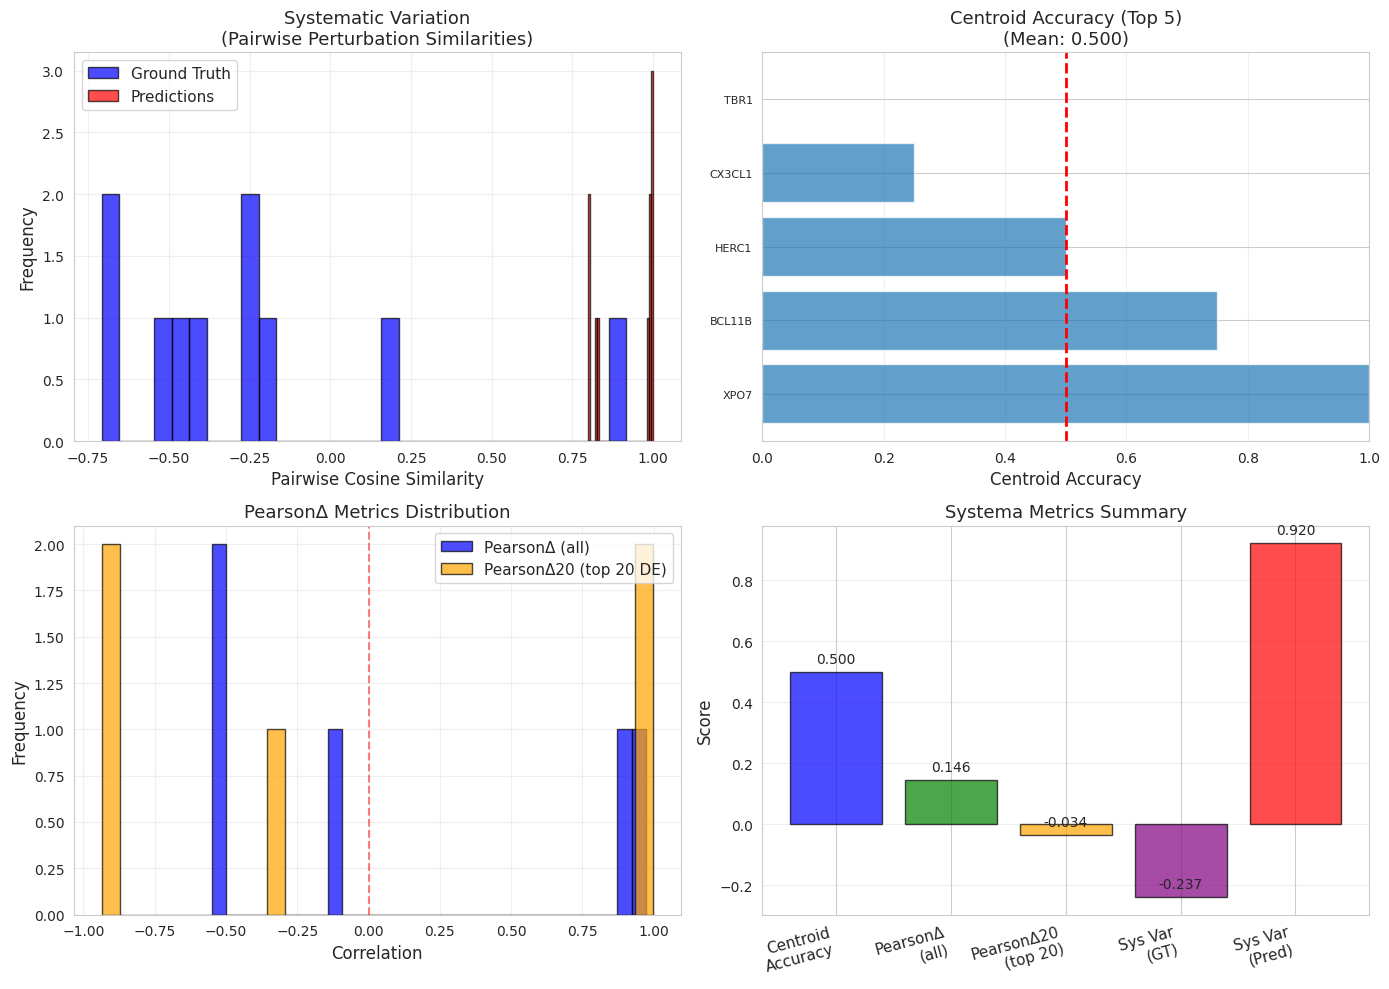


=== Final Summary ===
Number of conditions: 5
Centroid Accuracy: 0.500 ± 0.395
PearsonΔ (all): 0.146 ± 0.753
PearsonΔ20 (top 20 DE): -0.034 ± 0.968
Systematic Variation (GT): -0.237 ± 0.458
Systematic Variation (Pred): 0.920 ± 0.089


In [ ]:
# 1. Compute centroids for GT and predictions per condition
# 2. Quantify systematic variation (pairwise perturbation similarities)
# 3. Compute centroid accuracy metric
# 4. Compute PearsonΔ metrics (all genes and top 20 DE)
# 5. Create visualization plots

results = run_full_evaluation(
    adata, 
    pred, 
    Xpred, 
    PERT_COL=PERT_COL, 
    method_name="model"
)


In [19]:
# Access individual results if needed
print("\n=== Individual Results ===")
print(f"Centroid Accuracy DataFrame shape: {results['centroid_acc_df'].shape}")
print(f"PearsonΔ DataFrame shape: {results['pearson_df'].shape}")
print(f"\nCentroid Accuracy DataFrame:")
print(results['centroid_acc_df'].head())
print(f"\nPearsonΔ DataFrame:")
print(results['pearson_df'].head())



=== Individual Results ===
Centroid Accuracy DataFrame shape: (5, 1)
PearsonΔ DataFrame shape: (5, 3)

Centroid Accuracy DataFrame:
           model
condition       
BCL11B      0.75
CX3CL1      0.25
HERC1       0.50
TBR1        0.00
XPO7        1.00

PearsonΔ DataFrame:
   corr_all_allpert  corr_20de_allpert condition
0          0.917551           0.994787    BCL11B
1         -0.520772          -0.936302    CX3CL1
2         -0.092420          -0.348577     HERC1
3         -0.549217          -0.877446      TBR1
4          0.973733           0.997547      XPO7


# Summary: Systema Evaluation Results

This notebook performs comprehensive Systema evaluation using test-split predictions and ground-truth perturbed outcomes.

## Evaluation Pipeline

### 1. Data Preparation
- **Input**: Test-split predictions (`pred`) and ground-truth perturbed outcomes (`adata`)
- **Preprocessing**: 
  - Filtered to test split cells
  - Removed control cells (perturbations only)
  - Aligned genes between predictions and ground-truth
  - Computed centroids (mean expression) per condition

### 2. Systematic Variation Analysis
- **Metric**: Pairwise cosine similarity between perturbation shifts
- **Purpose**: Quantifies how similar different perturbations are to each other
- **Reference**: Average of all perturbation centroids (`pert_mean`)
- **Output**: 
  - Mean pairwise similarity for GT and predictions
  - Comparison of systematic variation patterns

### 3. Centroid Accuracy
- **Metric**: Rank-based identification accuracy
- **How it works**:
  - Computes Euclidean distance from each prediction to all ground-truth centroids
  - Identifies rank of correct centroid (how many others are farther away)
  - Score = fraction of centroids farther than correct one
- **Key Properties**:
  - **Rank-based**: Score depends only on rank position, not absolute distances
  - **Discrete**: With n conditions, only (n-1) possible score values
  - **Range**: 0.0 (farthest/worst) to 1.0 (closest/perfect)
- **Interpretation**:
  - 1.0 = Correct perturbation is closest (perfect identification)
  - 0.5 = Correct perturbation is at median rank
  - 0.0 = Correct perturbation is farthest (worst identification)

### 4. PearsonΔ Metrics
- **Metric**: Correlation between predicted and true deltas (relative to reference)
- **Two variants**:
  - **PearsonΔ (all genes)**: Correlation across all genes
  - **PearsonΔ20 (top 20 DE)**: Correlation on top 20 differentially expressed genes
- **Reference**: Average perturbation centroid (`pert_mean`)
- **Interpretation**:
  - Higher correlation = better prediction of perturbation effects
  - Positive values indicate agreement in direction of changes
  - Negative values indicate disagreement

## Results Format

### Centroid Accuracy Results
- **Format**: DataFrame with conditions as index, methods as columns
- **Values**: Rank-based accuracy scores (0.0 to 1.0)

### PearsonΔ Results
- DataFrame with conditions and two metrics
- **Col**: `corr_all_allpert`, `corr_20de_allpert`, `condition`
- **Values**: Pearson correlation coefficients (-1.0 to 1.0)

### Systematic Variation Results
- Arrays of pairwise cosine similarities
- Cosine similarity scores (-1.0 to 1.0)


1. **Centroid Accuracy** measures perturbation identification - whether the model can distinguish between different perturbations
2. **PearsonΔ** measures prediction quality - whether predicted changes match ground-truth changes in magnitude and direction
3. **Systematic Variation** measures perturbation structure - how similar perturbations are to each other in the embedding space
